In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import os
import joblib

from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [2]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts

In [3]:
import pandas as pd
def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams

In [4]:
df= pd.read_csv('Data-NLP/movie_reviews_v2.csv')
df

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0
...,...,...,...,...,...,...
8645,64ba5c5706f98400e1169ed0,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,"I'm not really a great fan of Tom Cruise. Yes,...",7.0
8646,64bdab4dad50f0013b127c02,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,Spectacular cinematic action let down by an in...,6.0
8647,64cca28c43cd5400add62db6,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,The Tom Cruise “Mission Impossible” franchise ...,9.0
8648,652e4978caef2d0139df3b6c,575264,tt9603212,Mission: Impossible - Dead Reckoning Part One,It was a good movie. Not better than the pervi...,8.0


In [5]:
df.isna().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [6]:
nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])
nlp_light.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [7]:
df = pd.read_csv('Data-NLP/movie_reviews_v2.csv')

# Preprocess and remove stopwords
df['tokens'] = batch_preprocess_texts(df['review'], nlp = nlp_light)
df.head()

8650it [00:30, 286.55it/s]


,review_id,movie_id,imdb_id,original_title,review,rating,tokens
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0,"[fine, piece, cinema, wong, kar, wai, tells, s..."
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es..."
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0,"[roommate, hates, stop, motion, animation, wat..."
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0,"[good, stop, motion, animation, <, em>'chicken..."
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0,"[ok, huge, temptation, riddle, review, puns, g..."


In [8]:
def categorize_rating(rating):
    if rating >= 9:
        return 'High-rating'
    elif rating <= 4:
        return 'Low-rating'
    else:
        return None

In [9]:
df['target'] = df['rating'].apply(categorize_rating)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,This is a fine piece of cinema from Wong Kar-W...,7.0,"[fine, piece, cinema, wong, kar, wai, tells, s...",None
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...",High-rating
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,Made my roommate who hates stop-motion animati...,6.0,"[roommate, hates, stop, motion, animation, wat...",None
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,A very good stop-motion animation!\r\n\r\n<em>...,8.0,"[good, stop, motion, animation, <, em>'chicken...",None
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this...",7.0,"[ok, huge, temptation, riddle, review, puns, g...",None


In [10]:
df.dropna(subset=['target'], inplace=True)
df

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...",High-rating
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...",Low-rating
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,"[entertainign, mission, impossible, second, in...",Low-rating
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,"[okay, admit, bit, easy, grader, comes, romant...",High-rating
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,"[scream, 3, lackluster, screenplay, unimaginat...",Low-rating
...,...,...,...,...,...,...,...,...
8629,6499e4de62f3350127477b22,569094,tt9362722,Spider-Man: Across the Spider-Verse,"I don't know, but in my humble opinion, the pu...",10.0,"[know, humble, opinion, punk, spider, man, nee...",High-rating
8631,64cca1752f266b09ef121de5,569094,tt9362722,Spider-Man: Across the Spider-Verse,I don’t have that much to say about “Spider-Ma...,9.0,"[spider, man, spider, verse, sequel, equally, ...",High-rating
8632,64de022bd100b614b2ef6547,569094,tt9362722,Spider-Man: Across the Spider-Verse,Incredible non stop action movie,10.0,"[incredible, non, stop, action, movie]",High-rating
8639,6529c2000929f6010090f513,565770,tt9362930,Blue Beetle,"I mean, it's not bad. It has the message, but...",10.0,"[mean, bad, message, screamed, lungs, like, mo...",High-rating


**NLTK and SpaCy for basic text processing**

In [11]:
lemmatizer = WordNetLemmatizer()

In [14]:
def lemmatize(review):
    doc = nlp_light(review)
    lemmatized_review = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return lemmatized_review

df['lemmas'] = df['review'].apply(lemmatize)
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target,lemmas
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...",High-rating,"[guilty, pleasure, personally, love, Great, Es..."
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...",Low-rating,"[underwhelme, straight, bore, course, see, Hun..."
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,"[entertainign, mission, impossible, second, in...",Low-rating,"[entertainign, Mission, Impossible, second, in..."
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy g...",9.0,"[okay, admit, bit, easy, grader, comes, romant...",High-rating,"[okay, admit, bit, easy, grader, come, romanti..."
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,**_Scream 3’s_ lackluster screenplay and unima...,4.0,"[scream, 3, lackluster, screenplay, unimaginat...",Low-rating,"[Scream, 3, lackluster, screenplay, unimaginat..."


In [15]:
def join_lemmatized_text(tokens):
    return ' '.join(tokens)

In [16]:
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))

df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...",High-rating,"[guilty, pleasure, personally, love, Great, Es...",guilty pleasure personally love great escape w...,guilty pleasure personally love Great Escape w...
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...",Low-rating,"[underwhelme, straight, bore, course, see, Hun...",underwhelmed straight bored course seeing hunt...,underwhelme straight bore course see Hunt clim...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I ...,2.0,"[entertainign, mission, impossible, second, in...",Low-rating,"[entertainign, Mission, Impossible, second, in...",entertainign mission impossible second install...,entertainign Mission Impossible second install...


In [17]:
# save the model using joblib

**EDA and Visualization**

In [18]:
filter_high = df['target'] == 'High-rating'
filter_low = df['target'] == 'Low-rating'

In [20]:
high_text = " ".join( df.loc[filter_high, 'lemmas-joined'])
print(high_text[:1000],"\n")

guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation okay admit bit easy grader come romantic comedy long witty likable character insult intelligence suitable happy ending guess end happily rom com 

 see movie year ago forget fresh like movie plot rely huge coincidence story get sappy sentimental place predictable religion suit thing suit fine praise co write direct actress Bonnie Hunt support character film 

 spark chemistry lead character dialogue smart sharp movie rich support cast Jim Belushi Robert Loggia Archie Bunker mean Carroll o’connor plus like Minnie Driver Circle Friends 

 mind Hitchcock Frank Capra stuff try let flow people scared day compliment be got to worry 

 Pitch Black direct David Twohy collectively write Twohy Ken Jim Wheat star Vin Diesel Radha Mitchell Cole Hauser Keith David Lewis Fitz Gerald Claudia Black Rhiana Griffith Music Graeme Revell cinematography 



In [22]:
low_text = " ".join( df.loc[filter_low, 'lemmas-joined'])
print(low_text[:1000],"\n")

underwhelme straight bore course see Hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped 

 set predominantly Australia grab attention say cause pretty biased come hear tell mission Impossible II low point series encouraging bad know able Rogue Nation 

 final rating: ★ ½ Boring disappointing avoid possible entertainign Mission Impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece crap movie Scream 3 lackluster screenplay unimaginative kill leave film bore watch 

 meta narrative trilogy film abysmal plot film create lore past movie seemingly blue muddle continuity shock value add little film feel force entire plot point Sidney mother Hollywood actress pretty lame especially add plot point sexually assault movie producer personal taste absolutely despise film add plo 



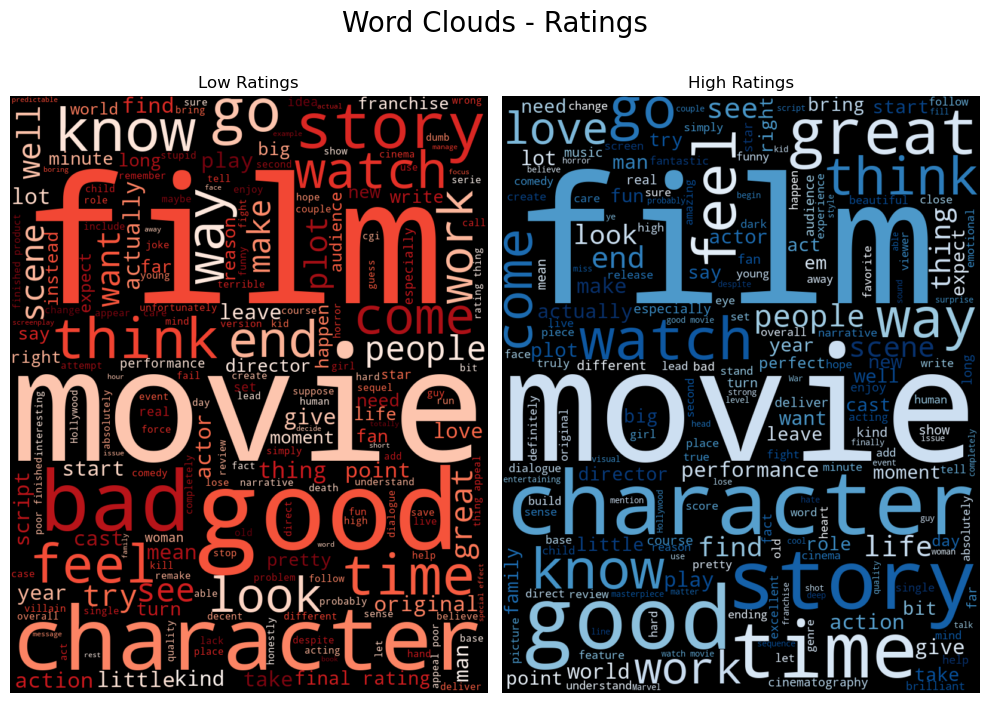

In [23]:
# Make word clouds of raw text
# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                     ).generate(low_text)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                      ).generate(high_text)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Ratings', fontsize=20, y=1.05);

In [24]:
image_folder = "Images"

low_cloud.to_file(os.path.join(image_folder, "low_ratings_wordcloud.png"))
high_cloud.to_file(os.path.join(image_folder, "high_ratings_wordcloud.png"))

In [25]:
# Make a single giant string with entire group of 5 star lemmas
high_lemmas = " ".join( df.loc[filter_high, 'lemmas-joined'])
# Make a single giant string with entire group of 1 star lemmas
low_lemmas= " ".join( df.loc[filter_low, 'lemmas-joined'])

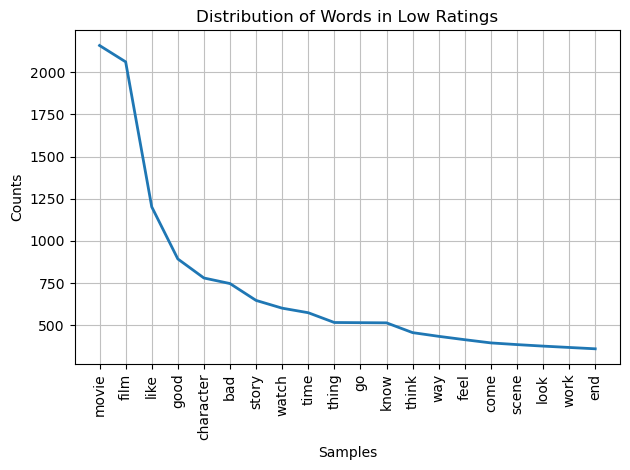

In [26]:
# Split the lemmas into individual token words
low_lemmas_split = low_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
low_dist = FreqDist(low_lemmas_split)
ax = low_dist.plot(20, show = False, title='Distribution of Words in Low Ratings')
plt.tight_layout()
plt.savefig('Images/low_rating_freq_dist.png')

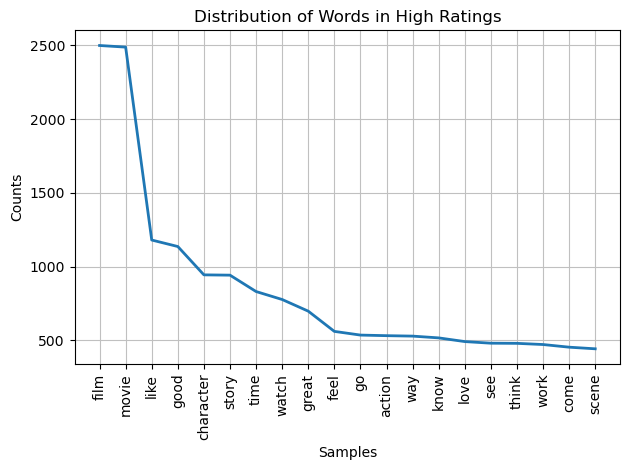

In [27]:
# Split the lemmas into individual token words
high_lemmas_split = high_lemmas.split()
# Pass the tokenized lemmas to the class constructor and plot the distribution 
high_dist = FreqDist(high_lemmas_split)
ax = high_dist.plot(20, show = False, title='Distribution of Words in High Ratings')
plt.tight_layout()
plt.savefig('Images/high_rating_freq_dist.png')

**N-grams**

In [28]:
# Make a single giant string with entire group of 5 star tokens
high_reviews_tokens = " ".join( df.loc[filter_high, 'tokens-joined'])
# Make a single giant string with entire group of 1 star tokens
low_reviews_tokens = " ".join( df.loc[filter_low, 'tokens-joined'])

In [29]:
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love...",9.0,"[guilty, pleasure, personally, love, great, es...",High-rating,"[guilty, pleasure, personally, love, Great, Es...",guilty pleasure personally love great escape w...,guilty pleasure personally love Great Escape w...
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straig...",3.0,"[underwhelmed, straight, bored, course, seeing...",Low-rating,"[underwhelme, straight, bore, course, see, Hun...",underwhelmed straight bored course seeing hunt...,underwhelme straight bore course see Hunt clim...


In [30]:
high_reviews_tokens_exploded_list = df.loc[filter_high, 'tokens'].explode().astype(str).to_list()
high_reviews_tokens_exploded_list[:5]

['guilty', 'pleasure', 'personally', 'love', 'great']

In [31]:
low_reviews_tokens_exploded_list = df.loc[filter_low, 'tokens'].explode().astype(str).to_list()
low_reviews_tokens_exploded_list[:5]

['underwhelmed', 'straight', 'bored', 'course', 'seeing']

In [32]:
# Instantiate a measures objects for Bigrams
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [33]:
bigram_finder_low = nltk.BigramCollocationFinder.from_words(low_reviews_tokens_exploded_list)

bigram_finder_high = nltk.BigramCollocationFinder.from_words(high_reviews_tokens_exploded_list)

In [34]:
bigrams_scores_low = bigram_finder_low.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_low[:10]

[(('final', 'rating'), 0.0011283696821171036),
 (('rating', '★'), 0.0011283696821171036),
 (('★', '★'), 0.001031400412560165),
 (('finished', 'product'), 0.0008462772615878277),
 (('appeal', 'poor'), 0.0008374618734462878),
 (('poor', 'finished'), 0.0008374618734462878),
 (('things', 'appeal'), 0.0008374618734462878),
 (('★', 'things'), 0.0008374618734462878),
 (('special', 'effects'), 0.0006435233343324106),
 (('feels', 'like'), 0.0005377386766339322)]

In [35]:
bigrams_scores_high = bigram_finder_high.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_high[:10]

[(('comic', 'book'), 0.00043644064764930204),
 (('special', 'effects'), 0.00043644064764930204),
 (('star', 'wars'), 0.0003935120593559281),
 (('sci', 'fi'), 0.00035773823577811645),
 (('feel', 'like'), 0.0003505834710625541),
 (('action', 'movie'), 0.00034342870634699175),
 (('watch', 'movie'), 0.00031480964748474246),
 (('john', 'wick'), 0.00030765488276918016),
 (('real', 'life'), 0.00030765488276918016),
 (('long', 'time'), 0.0003005001180536178)]

In [36]:
df_bigram_scores_high = pd.DataFrame(bigrams_scores_high, columns=['Words','Frequency'])
df_bigram_scores_high.head()

,Words,Frequency
0,"(comic, book)",0.000436
1,"(special, effects)",0.000436
2,"(star, wars)",0.000394
3,"(sci, fi)",0.000358
4,"(feel, like)",0.000351


In [37]:
# remove stopwords

In [38]:
df_bigram_scores_low = pd.DataFrame(bigrams_scores_low, columns=['Words','Frequency'])
df_bigram_scores_low.head()

,Words,Frequency
0,"(final, rating)",0.001128
1,"(rating, ★)",0.001128
2,"(★, ★)",0.001031
3,"(finished, product)",0.000846
4,"(appeal, poor)",0.000837


In [40]:
df.to_csv('ratings_model.csv', index=False)